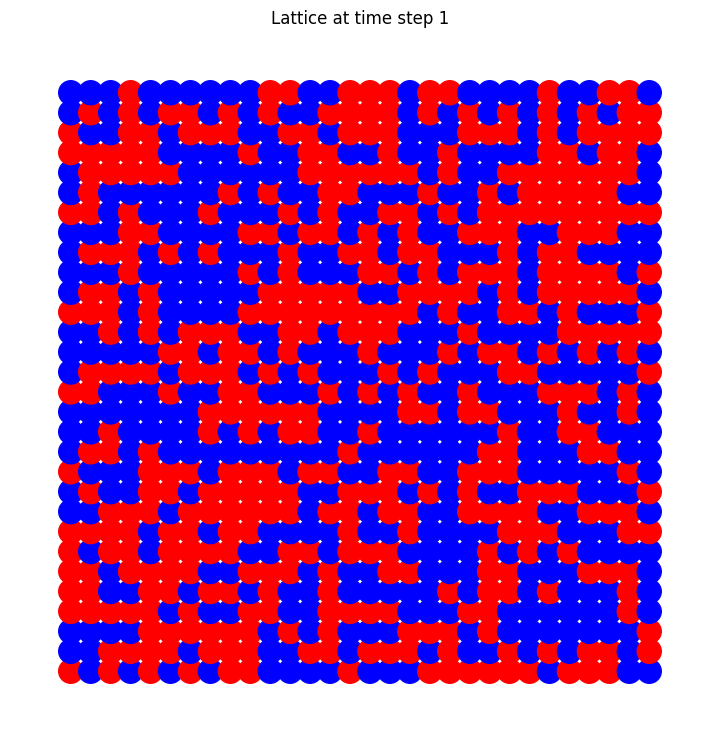

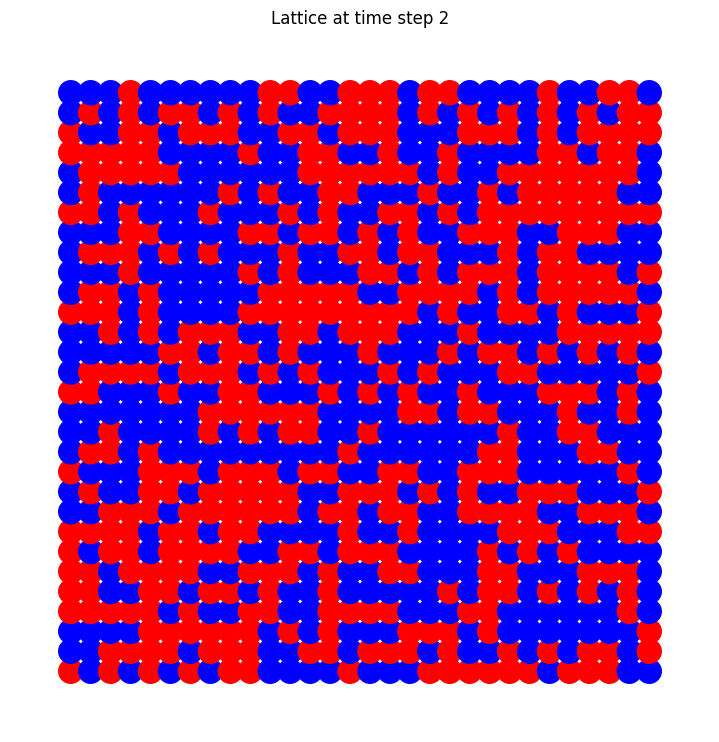

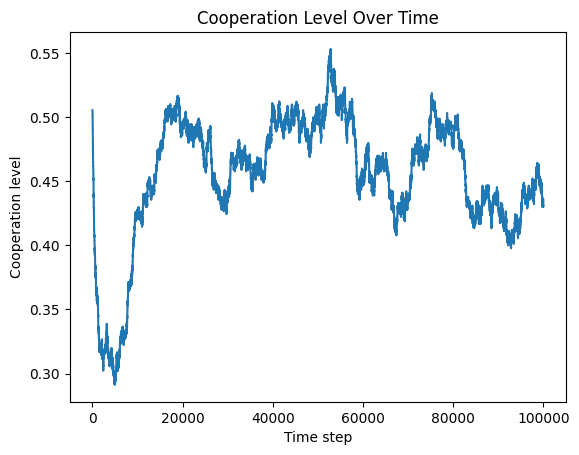

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import random
import networkx as nx

# Adjust grid size to 30x30
GRID_SIZE = 30
NUM_AGENTS = GRID_SIZE * GRID_SIZE  # Total number of agents
RICH_SITE_PROB = 0.0  # Fraction of rich sites (adjust as needed)
AVERAGE_SITE_PROB = 0.0  # Fraction of average sites (you can adjust as needed)
INITIAL_COOPERATION_PROB = 0.5
c = 10  # Resource contrast (c) between rich and poor sites
DEFECTOR_COST = 1  # A small cost or penalty for choosing defection
COOPERATION_CLUSTER_BONUS = 0.7
PUBLIC_GOOD_BONUS = 2  # r, public good bonus
b = 1.1  # Temptation to defect
TEMPTATION_LEVEL = b - 1
m = 10  # Parameter for strategy change

# Payoff matrix parameters
RICH_RESOURCE = 1 + c
AVERAGE_RESOURCE = (1 + c) / 2  # Average site resource
POOR_RESOURCE = 1

# Create a 2D grid of agents (lattice)
def create_lattice():
    G = nx.grid_2d_graph(GRID_SIZE, GRID_SIZE, periodic=True)  # 2D grid with periodic boundary
    assign_resources(G)
    initialize_strategies(G, INITIAL_COOPERATION_PROB)
    return G

# Assign resources to rich, poor, and average sites
def assign_resources(G):
    for node in G.nodes():
        rand = random.random()
        if rand < RICH_SITE_PROB:
            G.nodes[node]['resource'] = RICH_RESOURCE
            G.nodes[node]['site_type'] = 'rich'
        elif rand < RICH_SITE_PROB + AVERAGE_SITE_PROB:
            G.nodes[node]['resource'] = AVERAGE_RESOURCE
            G.nodes[node]['site_type'] = 'average'
        else:
            G.nodes[node]['resource'] = POOR_RESOURCE
            G.nodes[node]['site_type'] = 'poor'

# Initialize strategies for agents (either cooperate 'C' or defect 'D')
def initialize_strategies(G, cooperation_prob):
    for node in G.nodes():
        G.nodes[node]['strategy'] = 'C' if random.random() < cooperation_prob else 'D'

# Play the game for one time step and calculate payoffs
def play_game(G):
    payoffs = {}
    for node in G.nodes():
        strategy = G.nodes[node]['strategy']
        site = G.nodes[node]['site_type']
        payoff = 0
        neighbors = list(G.neighbors(node))

        for neighbor in neighbors:
            neighbor_strategy = G.nodes[neighbor]['strategy']
            neighbor_site = G.nodes[neighbor]['site_type']

            # Payoff matrix from the paper (rich, average, and poor site interactions)
            payoff += calculate_payoff(strategy, site, neighbor_strategy, neighbor_site)

        payoffs[node] = payoff
    return payoffs

def calculate_payoff(strategy, site, neighbor_strategy, neighbor_site):
    payoff = 0
    b_local = b
    c_local = c

    if site == 'rich':
        if strategy == 'C':
            if neighbor_strategy == 'C':
                payoff = 2 * c_local + 1
            else:
                payoff = c_local
        else:  # strategy == 'D'
            if neighbor_strategy == 'C':
                payoff = b_local * c_local + b_local + c_local
            else:
                payoff = b_local * c_local + b_local - 1
    else:  # site == 'poor'
        if strategy == 'C':
            if neighbor_strategy == 'C':
                payoff = 1
            else:
                payoff = 0
        else:  # strategy == 'D'
            if neighbor_strategy == 'C':
                payoff = b_local
            else:
                payoff = b_local - 1

    return payoff

# Update strategies based on payoffs and stochastic imitation
def update_strategies(G, payoffs):
    mutation_prob = 0.05  # Small chance of strategy mutation
    m = 10  # Exponent
    node = random.choice(list(G.nodes()))
    if random.random() < mutation_prob:
        # Mutate strategy
        current_strategy = G.nodes[node]['strategy']
        new_strategy = 'C' if current_strategy == 'D' else 'D'
    else:
        neighbors = list(G.neighbors(node))
        neighbors.append(node)  # Include self in possible models
        total_payoff = 0.0
        payoff_list = []

        # Compute total payoff raised to exponent m
        for neighbor in neighbors:
            payoff = payoffs[neighbor]
            payoff_m = max(payoff, 0) ** m  # Ensure non-negative before raising to m
            payoff_list.append((neighbor, payoff_m))
            total_payoff += payoff_m

        if total_payoff == 0:
            # All payoffs are zero or negative; choose randomly
            selected_neighbor = random.choice(neighbors)
        else:
            # Select a neighbor proportional to payoff^m
            probabilities = [payoff_m / total_payoff for _, payoff_m in payoff_list]
            selected_neighbor = random.choices(
                [neighbor for neighbor, _ in payoff_list],
                weights=probabilities,
                k=1
            )[0]

        new_strategy = G.nodes[selected_neighbor]['strategy']

    # Apply the new strategy to the node
    G.nodes[node]['strategy'] = new_strategy

def plot_lattice_old(G, timestep):
    # Color cooperators (blue) and defectors (red)
    strategy_map = {'C': 'blue', 'D': 'red'}
    node_colors = [strategy_map[G.nodes[node]['strategy']] for node in G.nodes()]
    
    # Draw the grid with proper node colors
    pos = dict((n, n) for n in G.nodes())  # Use grid positions
    plt.figure(figsize=(7, 7))
    
    # Increase node size to remove white spaces between dots
    nx.draw(G, pos, node_color=node_colors, with_labels=False, node_size=300, edge_color='black', width=0.05)
    
    plt.title(f"Lattice at time step {timestep}")
    plt.show()
# Visualization of the lattice with different colors for cooperators and defectors
# def plot_lattice(G, timestep):
#     node_colors = []
    
#     for node in G.nodes():
#         strategy = G.nodes[node].get('strategy')  # 'C' or 'D'
#         site_type = G.nodes[node].get('site_type')  # 'rich' or 'poor'

#         if strategy == 'C':
#             if site_type == 'rich':
#                 node_colors.append('lightblue')  # Cooperators on rich sites
#             else:
#                 node_colors.append('blue')       # Cooperators on poor sites
#         elif strategy == 'D':
#             if site_type == 'rich':
#                 node_colors.append('salmon')  # Defectors on rich sites
#             else:
#                 node_colors.append('red')        # Defectors on poor sites
#         else:
#             node_colors.append('grey')           # Default in case of missing strategy
    
#     # Draw the grid with proper node colors
#     pos = dict((n, n) for n in G.nodes())  # Use grid positions
#     plt.figure(figsize=(8, 8))
    
#     # Increase node size to remove white spaces between dots
#     nx.draw(G, pos, node_color=node_colors, with_labels=False, node_size=40, edge_color='black', width=0.05)
    
#     plt.title(f"Lattice at time step {timestep}")
#     plt.show()

# Simulation loop
def simulate():
    G = create_lattice()
    cooperation_levels = []

    for t in range(5000000):  # Simulate for 100,000 time steps
        payoffs = play_game(G)
        update_strategies(G, payoffs)
        
        num_cooperators = sum(1 for node in G.nodes() if G.nodes[node]['strategy'] == 'C')
        cooperation_level = num_cooperators / NUM_AGENTS
        cooperation_levels.append(cooperation_level)
        
        if t == 1:
            plot_lattice_old(G, t+1)
        if (t % 5000000 == 0) :
            #plot_lattice(G, t+1)
            plot_lattice_old(G, t+1)
    
    return cooperation_levels, G

# Run the simulation and plot the final state
cooperation_levels, G = simulate()

# Plot the cooperation level over time
plt.plot(cooperation_levels)
plt.xlabel("Time step")
plt.ylabel("Cooperation level")
plt.title("Cooperation Level Over Time")
plt.show()
